In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
dataset_path = "/content/drive/MyDrive/pcam"

# Example: List files to confirm
import os
print(os.listdir(dataset_path))

# Use with PyTorch (adjust paths to specific files)
train_image_file = os.path.join(dataset_path, "pcam/training_split.h5")
train_label_file = os.path.join(dataset_path, "Labels/Labels/camelyonpatch_level_2_split_train_y.h5")

Mounted at /content/drive
['camelyonpatch_level_2_split_train_mask', 'Labels', 'Metadata', 'pcam']


Number of training samples: 262144


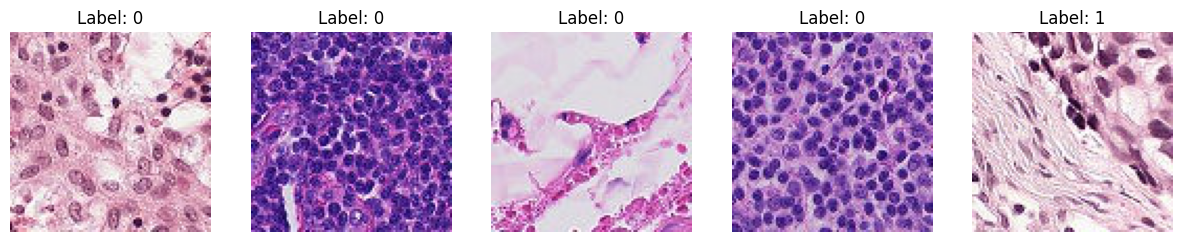

In [2]:
from google.colab import drive
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Step 2: Define the Dataset class with on-the-fly loading
class PatchCamelyonDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.image_file = image_file
        self.label_file = label_file
        self.transform = transform
        # Get the number of samples without loading the full dataset
        with h5py.File(image_file, 'r') as f:
            self.num_samples = len(f['x'])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Load only the specific image and label at the given index
        with h5py.File(self.image_file, 'r') as f:
            image = np.array(f['x'][idx])  # Shape: (96, 96, 3)
        with h5py.File(self.label_file, 'r') as f:
            label = np.array(f['y'][idx]).squeeze()  # Scalar (0 or 1)

        # Convert to PyTorch tensor and adjust dimensions
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (3, 96, 96)
        label = torch.tensor(label, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image / 255.0)  # Normalize to [0, 1]
        else:
            image = image / 255.0  # Default normalization

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create dataset and dataloader
train_dataset = PatchCamelyonDataset(train_image_file, train_label_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
print(f"Number of training samples: {len(train_dataset)}")

# Step 3: Visualize examples
def visualize_examples(loader, num_examples=5):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        img = images[i].permute(1, 2, 0).numpy()  # Convert (3, 96, 96) to (96, 96, 3)
        label = labels[i].item()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {int(label)}")
        axes[i].axis('off')
    plt.show()

# Visualize 5 examples from the training set
visualize_examples(train_loader, num_examples=5)


In [3]:
import torchvision.models as models
import torch.nn as nn

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-50 and modify for binary classification
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification with sigmoid
model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
# def train_resnet(model, train_loader, criterion, optimizer, num_epochs=5):
#     model.train()

#     for epoch in range(num_epochs):
#         running_loss = 0.0
#         correct_preds = 0
#         total_samples = 0

#         for images, labels in train_loader:
#             images = images.to(device)
#             labels = labels.to(device).unsqueeze(1)  # Shape: [batch_size, 1]

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             # Metrics
#             running_loss += loss.item() * images.size(0)
#             preds = torch.sigmoid(outputs) > 0.5
#             correct_preds += (preds == labels.bool()).sum().item()
#             total_samples += labels.size(0)

#         epoch_loss = running_loss / total_samples
#         epoch_acc = correct_preds / total_samples
#         print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

#     return model

# # Train the model
# trained_model = train_resnet(model, train_loader, criterion, optimizer, num_epochs=5)

# # Save the model
# torch.save(trained_model.state_dict(), '/content/resnet50_pcam_trained.pth')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]


In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score
def train_resnet(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Store loss and predictions
            running_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) > 0.5).int()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Convert to flat arrays
        all_preds = np.array(all_preds).flatten()
        all_labels = np.array(all_labels).flatten()

        # Calculate metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = (all_preds == all_labels).mean()
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} | "
              f"Acc: {accuracy:.4f} | Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f}")

        return model

# Train the model
trained_model = train_resnet(model, train_loader, criterion, optimizer, num_epochs=5)

Epoch [1/5] - Loss: 0.2454 | Acc: 0.9025 | Prec: 0.9134 | Rec: 0.8892 | F1: 0.9012


In [5]:

# Save the model
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/pcam/resnet50_pcam_trained.pth")